## Step 1: Create spark context

In [1]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
spark

In [3]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

## Step 2: Create a pandas dataframe

In [4]:
import pandas as pd
p_df = pd.read_csv('data/users.csv', sep='|')

In [5]:
p_df.head()

,1,24,M,technician,85711
0,2,53,F,other,94043
1,3,23,M,writer,32067
2,4,24,M,technician,43537
3,5,33,F,other,15213
4,6,42,M,executive,98101


## Step 3: Create spark object

#### AS RDD object

In [6]:
rdd = sc.textFile("data/users.csv")

In [7]:
rdd.take(5)

['1|24|M|technician|85711',
 '2|53|F|other|94043',
 '3|23|M|writer|32067',
 '4|24|M|technician|43537',
 '5|33|F|other|15213']

In [8]:
#What does .map do?
rdd = sc.textFile("data/users.csv").map(lambda line: line.split("|"))

In [9]:
rdd.take(5)

[['1', '24', 'M', 'technician', '85711'],
 ['2', '53', 'F', 'other', '94043'],
 ['3', '23', 'M', 'writer', '32067'],
 ['4', '24', 'M', 'technician', '43537'],
 ['5', '33', 'F', 'other', '15213']]

In [10]:
type(rdd)

pyspark.rdd.PipelinedRDD

... 
### Take 5 minutes to explore various methods of rdd
...


#### As a DF object

In [11]:
df = spark.read.csv("data/users.csv", sep="|")

In [12]:
type(df)

pyspark.sql.dataframe.DataFrame

In [13]:
df.take(5)

[Row(_c0='1', _c1='24', _c2='M', _c3='technician', _c4='85711'),
 Row(_c0='2', _c1='53', _c2='F', _c3='other', _c4='94043'),
 Row(_c0='3', _c1='23', _c2='M', _c3='writer', _c4='32067'),
 Row(_c0='4', _c1='24', _c2='M', _c3='technician', _c4='43537'),
 Row(_c0='5', _c1='33', _c2='F', _c3='other', _c4='15213')]

In [14]:
# it's already a DF, but this is the easy way to rename columns
df = (spark.read.csv("data/users.csv", sep="|")
           .toDF("id", "age", "gender", "occupation", "zip"))

In [15]:
df.take(5)

[Row(id='1', age='24', gender='M', occupation='technician', zip='85711'),
 Row(id='2', age='53', gender='F', occupation='other', zip='94043'),
 Row(id='3', age='23', gender='M', occupation='writer', zip='32067'),
 Row(id='4', age='24', gender='M', occupation='technician', zip='43537'),
 Row(id='5', age='33', gender='F', occupation='other', zip='15213')]

In [16]:
# putting into parathensis allows us not to worry about extra line spaces
(
    df.where("occupation != 'other'")
      .groupby("occupation")
      .count()
      .sort("count", ascending=0)
      .show()
)

+-------------+-----+
|   occupation|count|
+-------------+-----+
|      student|  196|
|     educator|   95|
|administrator|   79|
|     engineer|   67|
|   programmer|   66|
|    librarian|   51|
|       writer|   45|
|    executive|   32|
|    scientist|   31|
|       artist|   28|
|   technician|   27|
|    marketing|   26|
|entertainment|   18|
|   healthcare|   16|
|      retired|   14|
|     salesman|   12|
|       lawyer|   12|
|         none|    9|
|    homemaker|    7|
|       doctor|    7|
+-------------+-----+



In [17]:
#.persist 
df.persist()

DataFrame[id: string, age: string, gender: string, occupation: string, zip: string]

In [18]:
df.limit(5).toPandas()
#df.head()
#df.show(5)

,id,age,gender,occupation,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [19]:
# def show(df, n=5):
#     return df.limit(n).toPandas()

### SQL

In [20]:
import pyspark.sql.functions as F

In [21]:
df.agg(F.countDistinct('occupation')).show()

+--------------------------+
|count(DISTINCT occupation)|
+--------------------------+
|                        21|
+--------------------------+



In [29]:
query = """
SELECT occupation, COUNT(*) as count
FROM users
GROUP BY occupation
ORDER BY count DESC
"""

df.createOrReplaceTempView('users')

output = spark.sql(query)

output.show(10)

+-------------+-----+
|   occupation|count|
+-------------+-----+
|      student|  196|
|        other|  105|
|     educator|   95|
|administrator|   79|
|     engineer|   67|
|   programmer|   66|
|    librarian|   51|
|       writer|   45|
|    executive|   32|
|    scientist|   31|
+-------------+-----+
only showing top 10 rows



### Machine Learning with Spark

In [30]:
titanic = spark.read.csv(path='data/titanic_clean.csv', sep=',',
                     encoding='UTF-8', header=True, inferSchema=True)

In [31]:
def show(df, n=5):
    return df.limit(n).toPandas()

### Do some basic data exploration

In [32]:
titanic.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked']

In [33]:
titanic.dtypes

[('PassengerId', 'int'),
 ('Survived', 'int'),
 ('Pclass', 'int'),
 ('Name', 'string'),
 ('Sex', 'string'),
 ('Age', 'double'),
 ('SibSp', 'int'),
 ('Parch', 'int'),
 ('Fare', 'double'),
 ('Embarked', 'string')]

In [34]:
titanic.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = true)



In [35]:
titanic.limit(10).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
5,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S
6,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S
7,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S
8,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C
9,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,16.7000,S


In [36]:
titanic.count()

712

In [37]:
titanic.groupBy('Sex').count().show()

+------+-----+
|   Sex|count|
+------+-----+
|female|  259|
|  male|  453|
+------+-----+



In [38]:
# Create a new column is female "sex"
from pyspark.sql.functions import when, col
titanic = titanic.withColumn("is_female",
                     (when(col("Sex").like("%female%"), 1)
                      .otherwise(0)))

In [ ]:
# drop original target column
titanic = titanic.drop("Name", "Sex", "Embarked")

In [39]:
# Set survived as label and lowercase column names
titanic = titanic.selectExpr("Survived as label", "PassengerId as p_id" , "Survived as survived", "Pclass as pclass", "is_female as is_female", "Age as age", "SibSp as sib", "Parch as parch", "Fare as fare")

In [40]:
show(titanic, 5)

,label,p_id,survived,pclass,is_female,age,sib,parch,fare
0,0,1,0,3,0,22.0,1,0,7.2500
1,1,2,1,1,1,38.0,1,0,71.2833
2,1,3,1,3,1,26.0,0,0,7.9250
3,1,4,1,1,1,35.0,1,0,53.1000
4,0,5,0,3,0,35.0,0,0,8.0500


#### Setting Features and Labels 

In [43]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ["p_id", "pclass", "is_female", "age", "sib", "parch", "fare"], outputCol = 'features')
vhouse_df = vectorAssembler.transform(titanic)
vhouse_df = vhouse_df.select(['features', 'label'])
vhouse_df.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,3.0,0.0,22.0...|    0|
|[2.0,1.0,1.0,38.0...|    1|
|[3.0,3.0,1.0,26.0...|    1|
+--------------------+-----+
only showing top 3 rows



## Machine Learning in Spark

Spark's [documentation](https://spark.apache.org/docs/2.2.0/ml-guide.html#mllib-main-guide) is fairly straight forward!  Let's take a look. It shouldn't look *too* different than `sklearn`

In [44]:
training_data, test_data = vhouse_df.randomSplit([0.7, 0.3], seed=100)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 487
Test Dataset Count: 225


### Logistic Regression

In [47]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol='label', maxIter=20, regParam=0.3, elasticNetParam=0)
lr_model = lr.fit(training_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.00012857786439025406,-0.29141359929279465,0.9439338621577505,-0.008204924609738736,-0.053221641160273225,0.04905300527354308,0.0023391835621167554]
Intercept: -0.057088887132624014


### Summary has many components one can call

In [48]:
# Extract the summary from the returned LogisticRegressionModel instance trained
training_summary = lr_model.summary

training_summary.areaUnderROC

0.8282070517629403

In [50]:
import matplotlib.pyplot as plt

areaUnderROC: 0.8282070517629403


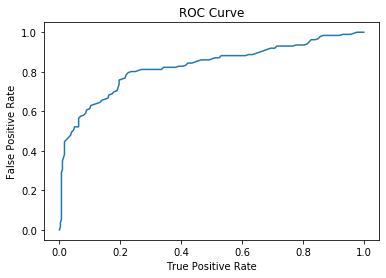

In [51]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(training_summary.areaUnderROC))

#training_summary.roc.show(n=10, truncate=15)
roc = training_summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [52]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lr_model.transform(test_data)

In [53]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(training_summary.areaUnderROC))

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.8282070517629403
Test: Area Under ROC: 0.8896062490036672


### Naive Bayes
#### Specify and fit the model

In [54]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial")

# train the model
model = nb.fit(training_data)

#### Evaluate Naive Bayes

In [55]:
# select example rows to display.
predictions = model.transform(test_data)

# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions,
                                                        {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.6621233859397417


### Decision Tree
#### Fit model

In [56]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(training_data)

In [57]:
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)

numNodes =  11
depth =  3


#### Evaluate Decision Tree

In [58]:
predictions = dtModel.transform(test_data)

In [59]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions,
                                                        {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.7354136776661884


### Random Forest
#### Specify model

In [60]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=100,
                            maxDepth=4,
                            maxBins=32)

# Train model with Training Data
rfModel = rf.fit(training_data)

#### Score and evaluate Random Forest

In [61]:
# Score test Data
predictions = rfModel.transform(test_data)

In [62]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions,
                                                        {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9034353578829906


### Implementing grid search with `CrossValidator` in pyspark

In [63]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200])  # number of trees
             .addGrid(rf.maxDepth, [3, 4, 5])       # maximum depth
             .addGrid(rf.maxBins, [24, 32, 40])   # Number of bins
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=5)

# Run cross validations
cv_model = cv.fit(training_data)

# Use test set here so we can measure the accuracy of our model on new data
predictions = cv_model.transform(test_data)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions,
                                                        {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9060656783038423


## Which model had the best AUC?

### Learning goals in review. How did we do?
- Align the relationships between Hadoop and Spark
- Differentiate between Spark RDDs and Spark Dataframes and when each is appropriate
- Locate and explore the Spark.ML documentation
- Code along to see how pyspark is similar differnt to python (sklearn/pandas)